#### Данные своего варианта (см. таблицу ниже) разделить на выборку для построения моделей (80%) и отложенные наблюдения (20%). Оставить в таблице только указанные в варианте переменные. 

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
# загрузка пакетов: модели -------------------------------------------------
# линейные модели
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
# кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score
my_seed = 22
plt = mpl.pyplot
mpl.style.use('bmh')

In [2]:
df_raw = pd.read_csv('./Boston_for_lab.csv')

df_all = df_raw[['nox', 'rm', 'medv', 'tax_over_400']]

df = df_all.sample(frac = 0.8, random_state = my_seed)
df_predict = df_all.drop(df.index)

#### Провести предварительный анализ данных с помощью описательных статистик и графиков, оценить взаимосвязь.

In [3]:
df[['medv', 'rm', 'nox']].describe()

,medv,rm,nox
count,405.000000,405.000000,405.000000
mean,23.013333,6.321980,0.549839
std,9.476099,0.703759,0.114479
min,5.000000,4.138000,0.385000
25%,17.400000,5.888000,0.448000
50%,21.500000,6.232000,0.524000
75%,26.500000,6.649000,0.624000
max,50.000000,8.780000,0.871000


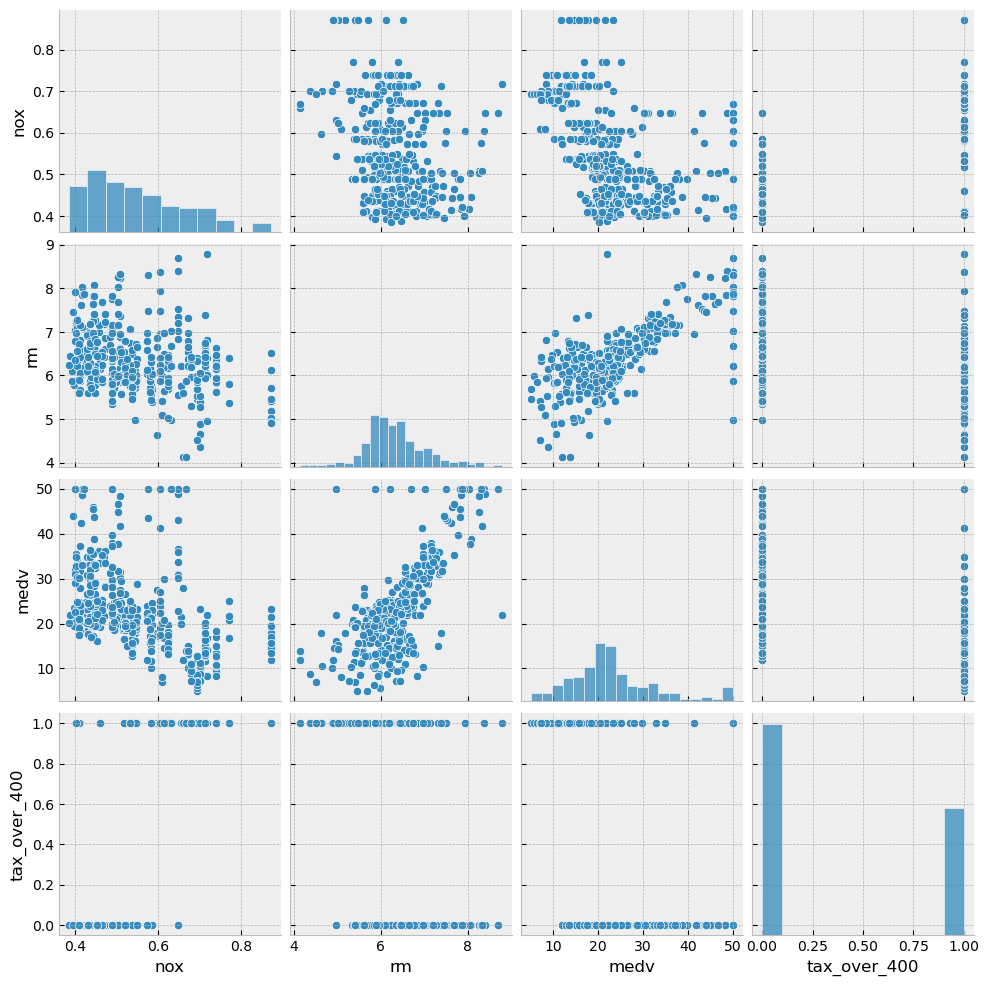

In [4]:
sns.pairplot(df)
plt.show()

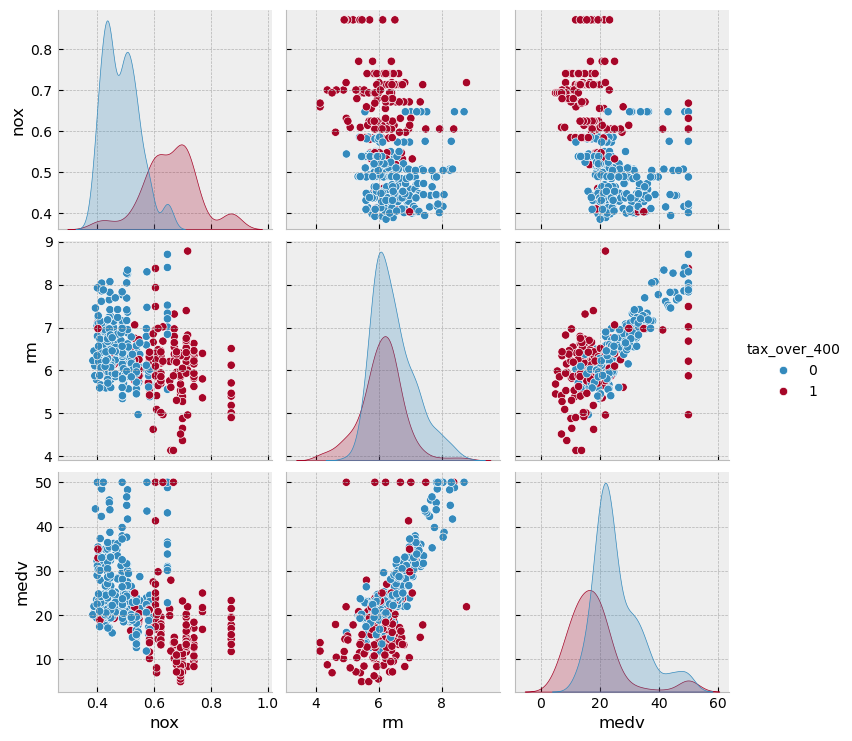

In [5]:
sns.pairplot(df, hue='tax_over_400')
plt.show()

In [6]:
df['nox_over_0.6'] =  df.nox.apply(lambda x: np.where(x < 0.6, 0, 1))
df['medv_binary'] = df.medv.apply(lambda x: np.where(x < 19, 0, 1))

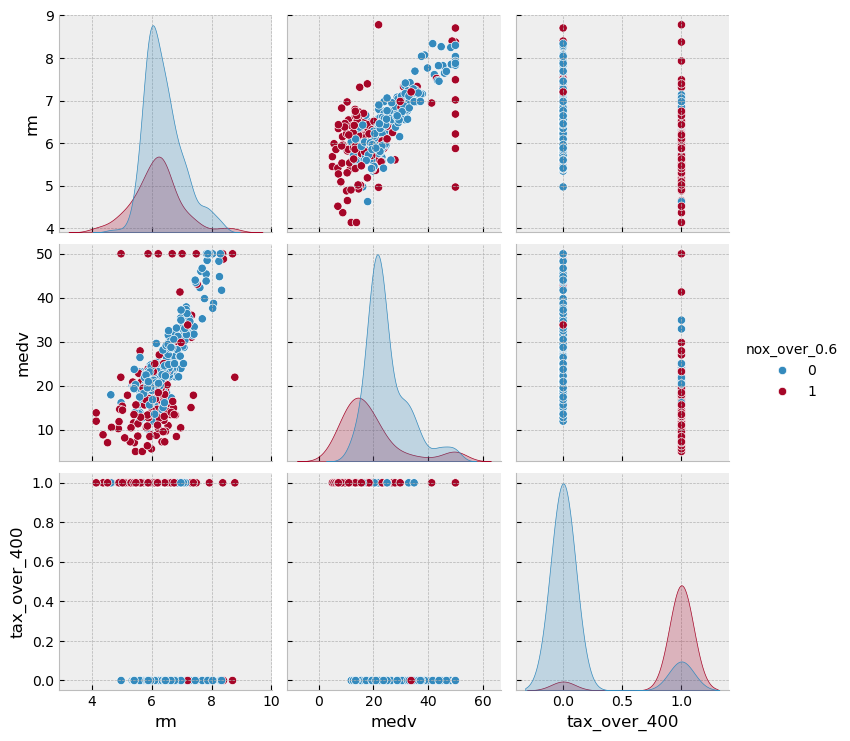

In [7]:
sns.pairplot(df[['rm', 'medv', 'tax_over_400', 'nox_over_0.6']], hue='nox_over_0.6')
plt.show()

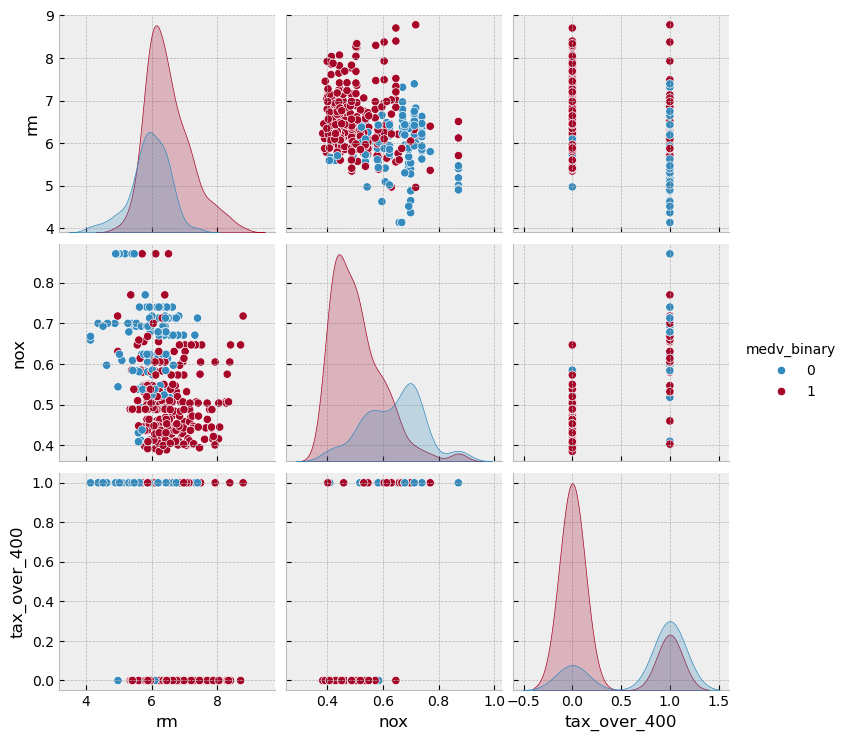

In [8]:
sns.pairplot(df[['rm', 'nox', 'tax_over_400', 'medv_binary']], hue='medv_binary')
plt.show()

nox и tax_over_400 имеют большую корреляцию, при этом на medv из них имеет большее влияние tax_over_400.

In [9]:
# корреляционная матрица по всем наблюдениям
corr_mat = df[['nox', 'rm', 'medv', 'tax_over_400']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,nox,rm,medv,tax_over_400
nox,1.00,-0.27,-0.41,0.74
rm,-0.27,1.00,0.71,-0.25
medv,-0.41,0.71,1.00,-0.39
tax_over_400,0.74,-0.25,-0.39,1.00


In [10]:
corr_mat = df.loc[df['tax_over_400'] == 0][['nox', 'rm', 'medv']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,nox,rm,medv
nox,1.00,-0.07,-0.09
rm,-0.07,1.00,0.90
medv,-0.09,0.90,1.00


In [11]:
corr_mat = df.loc[df['tax_over_400'] == 1][['nox', 'rm', 'medv']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,nox,rm,medv
nox,1.00,-0.20,-0.29
rm,-0.20,1.00,0.39
medv,-0.29,0.39,1.00


In [12]:
corr_mat = df.loc[df['nox_over_0.6'] == 0][['rm', 'medv', 'tax_over_400']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,rm,medv,tax_over_400
rm,1.00,0.87,-0.14
medv,0.87,1.00,-0.22
tax_over_400,-0.14,-0.22,1.00


In [13]:
corr_mat = df.loc[df['nox_over_0.6'] == 1][['rm', 'medv', 'tax_over_400']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,rm,medv,tax_over_400
rm,1.00,0.51,-0.41
medv,0.51,1.00,-0.44
tax_over_400,-0.41,-0.44,1.00


#### Проверить Y на нормальность. Если он распределён не по нормальному закону, прологарифмировать и снова провести анализ взаимосвязей переменных.

In [14]:
stat, p = shapiro(df['medv'])
print('medv', 'Statistics=%.2f, p=%.4f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Распределение нормально (H0 не отклоняется)\n')
else:
    print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



In [15]:
df['log_medv'] = np.log(df['medv'])
df[['medv', 'log_medv', 'rm', 'nox']].describe()

,medv,log_medv,rm,nox
count,405.000000,405.000000,405.000000,405.000000
mean,23.013333,3.053027,6.321980,0.549839
std,9.476099,0.417091,0.703759,0.114479
min,5.000000,1.609438,4.138000,0.385000
25%,17.400000,2.856470,5.888000,0.448000
50%,21.500000,3.068053,6.232000,0.524000
75%,26.500000,3.277145,6.649000,0.624000
max,50.000000,3.912023,8.780000,0.871000


In [16]:
stat, p = shapiro(df['log_medv'])
print('log_medv', 'Statistics=%.2f, p=%.4f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Распределение нормально (H0 не отклоняется)\n')
else:
    print('Распределение не нормально (H0 отклоняется)\n')

log_medv Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)



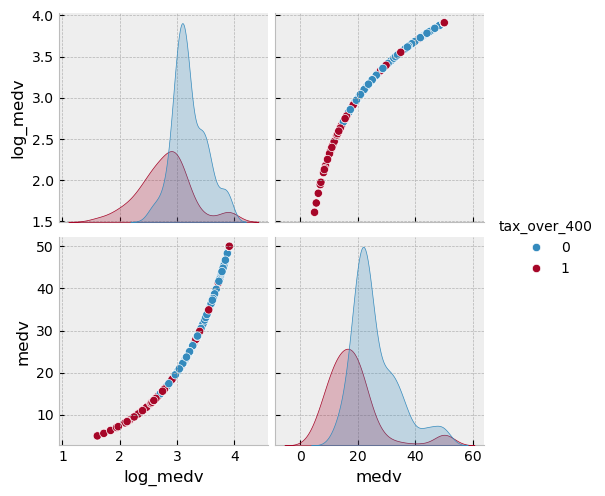

In [17]:
sns.pairplot(df[['log_medv', 'medv', 'tax_over_400']], hue='tax_over_400')
plt.show()

In [18]:
corr_mat = df.loc[df['tax_over_400'] == 0][['log_medv', 'nox', 'rm']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,log_medv,nox,rm
log_medv,1.00,-0.13,0.88
nox,-0.13,1.00,-0.07
rm,0.88,-0.07,1.00


In [19]:
corr_mat = df.loc[df['tax_over_400'] == 1][['log_medv', 'nox', 'rm']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,log_medv,nox,rm
log_medv,1.00,-0.31,0.38
nox,-0.31,1.00,-0.20
rm,0.38,-0.20,1.00


In [20]:
corr_mat = df.loc[df['nox_over_0.6'] == 0][['log_medv', 'rm', 'nox']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,log_medv,rm,nox
log_medv,1.00,0.85,-0.40
rm,0.85,1.00,-0.29
nox,-0.40,-0.29,1.00


In [21]:
corr_mat = df.loc[df['nox_over_0.6'] == 1][['rm', 'log_medv', 'nox']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

,rm,log_medv,nox
rm,1.00,0.49,-0.26
log_medv,0.49,1.00,-0.25
nox,-0.26,-0.25,1.00


#### Составить список возможных спецификаций моделей множественной регрессии (на исходной Y и на логарифме Y ).

In [22]:
df1 = df[['medv', 'tax_over_400', 'rm']]

df2 = df[['medv', 'tax_over_400', 'rm']]
df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['rm'], axis=1)

df3 = df[['medv', 'tax_over_400', 'rm']]
df3.loc[:, 'rm_tax_over_400'] = df3.loc[:, 'rm'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['rm', 'tax_over_400'], axis=1)

df4 = df[['medv', 'tax_over_400', 'rm']]
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']

df5 = df[['medv', 'tax_over_400', 'rm']]
df5.loc[:, 'rm_tax_over_400'] = df5.loc[:, 'rm'] * df5.loc[:, 'tax_over_400']
df5 = df5.drop(['tax_over_400'], axis=1)

df6 = df[['medv', 'rm']]

df0 = df.drop(['log_medv', 'nox', 'medv_binary'], axis=1)

/tmp/ipykernel_28346/2544282921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
/tmp/ipykernel_28346/2544282921.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'rm_tax_over_400'] = df3.loc[:, 'rm'] * df3.loc[:, 'tax_over_400']
/tmp/ipykernel_28346/2544282921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



#### Оценить параметры моделей из списка. Оценить точность моделей методом перекрёстной проверки, указанным в варианте. Найти самую точную из моделей для Y. Найти самую точную из моделей для log(Y).

In [23]:
lm = skl_lm.LinearRegression()
# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n',
    'константа ', np.around(fit_lm_0.intercept_, 3),
    '\n объясняющие ', list(X.columns.values),
    '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [-30.883] 
 объясняющие  ['rm', 'tax_over_400', 'nox_over_0.6'] 
 коэффициенты  [[ 8.789 -4.04  -0.472]]


In [24]:
# оценим MSE на обучающей
# прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([40.35309239])

In [25]:
# модель со всеми объясняющими, y_log
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n',
'константа ', np.around(fit_lm_0_log.intercept_, 3),
'\n объясняющие ', list(X.columns.values),
'\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [1.035] 
 объясняющие  ['rm', 'tax_over_400', 'nox_over_0.6'] 
 коэффициенты  [[ 0.337 -0.192 -0.132]]


In [26]:
# пересчёт константы для интерпретации
np.round(np.exp(fit_lm_0_log.intercept_), 1)

array([2.8])

In [27]:
# пересчёт коэффициентов для их интерпретации
np.round((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 40.1, -17.5, -12.4]])

In [28]:
# оценим MSE на обучающей
# прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log

array([37.21219513])

In [29]:
print('MSE_train модели для medv больше MSE_train',
'модели для log(medv) в', np.around(MSE / MSE_log, 1)[0], 'раз')

MSE_train модели для medv больше MSE_train модели для log(medv) в 1.1 раз


In [30]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4, df5, df6] :
    X = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10, scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1
# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.26 секунд


In [31]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4', 'fit_lm_5', 'fit_lm_6']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
fits[scores.index(max(scores))],
':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_4 :
MSE_kf10 = 38.0


In [32]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4, df5, df6] :
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i], shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10, scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1
# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.27 секунд


In [33]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 'fit_lm_3_log', 'fit_lm_4_log', 'fit_lm_5_log', 'fit_lm_6_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
fits[scores_log.index(max(scores_log))],
':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_4_log :
MSE_kf10 = 0.082


#### Сделать прогноз с помощью самых точных моделей на отложенные наблюдения. Рассчитать MSEtest вручную и выбрать одну наиболее точную модель. Проинтерпретировать её параметры.

In [34]:
# прогноз по fit_lm_4
# модель на всех обучающих наблюдениях
X = df4.drop(['medv'], axis=1)
y = df4.medv.values.reshape(-1, 1)
fit_lm_4 = lm.fit(X, y)
# значения y на отложенных наблюдениях
y = df_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
X = df_predict[['tax_over_400', 'rm']]
X.loc[:, 'rm_tax_over_400'] = X.loc[:, 'rm'] * X.loc[:, 'tax_over_400']
# прогнозы
y_pred = fit_lm_4.predict(X)
# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_4 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_4 на отложенных наблюдениях = 29.16


/tmp/ipykernel_28346/2324226300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'rm_tax_over_400'] = X.loc[:, 'rm'] * X.loc[:, 'tax_over_400']
/tmp/ipykernel_28346/2324226300.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_4 на отложенных наблюдениях = %.2f' % MSE)


In [35]:
# прогноз по fit_lm_4_log
# модель
X = df4.drop(['medv'], axis=1)
y = np.log(df4.medv).values.reshape(-1, 1)
fit_lm_4_log = lm.fit(X, y)
# значения y на отложенных наблюдениях
y = np.log(df_predict[['medv']].values.reshape(-1, 1))
# матрица объясняющих на отложенных наблюдениях
X = df_predict[['tax_over_400', 'rm']]
X.loc[:, 'rm_tax_over_400'] = X.loc[:, 'rm'] * X.loc[:, 'tax_over_400']
# прогнозы
y_pred = fit_lm_4_log.predict(X)
# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_4_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_4_log на отложенных наблюдениях = 27.00


/tmp/ipykernel_28346/1149995365.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'rm_tax_over_400'] = X.loc[:, 'rm'] * X.loc[:, 'tax_over_400']
/tmp/ipykernel_28346/1149995365.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_4_log на отложенных наблюдениях = %.2f' % MSE_log)


На выборке для прогноза точнее модель fit_lm_4_log.

In [36]:
# ещё раз строим на обучающей
X = df4.drop(['medv'], axis=1)
y = df4.medv.values.reshape(-1, 1)
fit_lm_4_log = lm.fit(X, y)
print('модель fit_lm_4_log:\n',
 'константа ', np.around(fit_lm_4_log.intercept_, 3),
 '\n объясняющие ', list(df4.drop(['medv'], axis=1).columns.values),
 '\n коэффициенты ', np.around(fit_lm_4_log.coef_, 3))

модель fit_lm_4_log:
 константа  [-45.193] 
 объясняющие  ['tax_over_400', 'rm', 'rm_tax_over_400'] 
 коэффициенты  [[31.229 11.001 -5.713]]


In [43]:
# ещё раз строим на обучающей
X = df4.drop(['medv'], axis=1)
y = np.log(df4.medv).values.reshape(-1, 1)
fit_lm_4_log = lm.fit(X, y)
# делаем данные для модели из отложенных наблюдений
df4 = df_predict[['medv', 'rm', 'tax_over_400']]
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']
X = df4.drop(['medv'], axis=1)
y = np.log(df4.medv).values.reshape(-1, 1)
# прогноз
y_pred = fit_lm_4_log.predict(X)
# ошибкаict[['medv', 'rm', 'tax_over_400']]
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.around(MSE_log, 2)[0]

27.81

In [47]:
# сравниваем ошибку со средним значением Y на отложенных
print('Ошибка модели на отложенных наблюдениях составила ',
    np.around(np.sqrt(MSE_log) / np.mean(np.exp(y)) * 100, 1)[0],
    '% от среднего значения Y', sep='')

Ошибка модели на отложенных наблюдениях составила 25.6% от среднего значения Y
